TODO:
 * Stepper motor skipping steps--more current (better power supply)?
 * Normalize action and observation spaces (see: https://ai.stackexchange.com/questions/21477/why-do-we-also-need-to-normalize-the-actions-values-on-continuous-action-spaces)

In [1]:
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.1.0
# !python -m pip install ax-platform==0.3.4

In [2]:
# Check versions
import importlib.metadata

print(f"torch version: {importlib.metadata.version('torch')}")
print(f"gymnasium version: {importlib.metadata.version('gymnasium')}")
print(f"sb3 version: {importlib.metadata.version('stable-baselines3')}")
print(f"cv2 version: {importlib.metadata.version('opencv-python')}")
print(f"ax version: {importlib.metadata.version('ax-platform')}")

torch version: 2.0.0
gymnasium version: 0.28.1
sb3 version: 2.1.0
cv2 version: 4.7.0.68
ax version: 0.3.4


In [92]:
# Python Standard Library
import time
import datetime
import os
import random
import logging
import math
import csv
from typing import Any, Dict, Tuple, Union

# Encoder and stepper controls (local)
from control_comms import ControlComms, StatusCode, DebugLevel

# Third-party packages
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Reinforcement model modules
import stable_baselines3 as sb3
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger

# Meta Ax
from ax.service.ax_client import AxClient
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

## Settings

In [4]:
# Communication settings
SERIAL_PORT = "COM6"    # Check your devices
BAUD_RATE = 500000      # Must match what's in the Arduino code!
CTRL_TIMEOUT = 1.0      # Seconds
DEBUG_LEVEL = DebugLevel.DEBUG_ERROR

# Reinforcement learning settings
K_T = 5                 # Reward constant to multiply theta (angle of encoder)
K_DT = 0.05             # Reward constant to multiply dtheto/dt (angular velocity of encoder)
K_P = 2                 # Reward constant to multiply phi (angle of stepper)
K_DP = 0.05             # Reward constant to multiply dphi/dt (angular velocity of stepper)
REWARD_OOB = -500       # Reward (penalty) for having the stepper motor move out of bounds (OOB)
ENC_ANGLE_NORM = 180    # Divide by this to normalize +/-180 deg angle to +/-1
STP_MOVE_MIN = -10.0
STP_MOVE_MAX = 10.0
STP_ANGLE_MIN = -180    # Episode ends if stepper goes beyond this angle
STP_ANGLE_MAX = 180     # Episode ends if stepper goes beyond this angle
STP_ANGLE_NORM = 180    # Divide by this to normalize +/-180 deg angle to +/-1

ENV_TIMEOUT = 10.0
RESET_SETTLE_TIME = 2.0 # Seconds to wait after reset to start moving again

# Angle constants
ENC_OFFSET = 180.0      # Pendulum in the "up" position should be 0 deg
ANG_REV = 360           # Degrees in a single revolution

In [5]:
# Communication constants
CMD_SET_HOME = 0        # Set current stepper position as home (0 deg)
CMD_MOVE_TO = 1         # Move stepper to a particular position (deg)
CMD_MOVE_BY = 2         # Move stepper by a given amount (deg)
CMD_SET_STEP_MODE = 3   # Set step mode
CMD_SET_BLOCK_MODE = 4  # Set blocking mode
CMD_NOP = 5             # Take no action, just receive observation
STEP_MODE_1 = 0         # 1 division per step
STEP_MODE_2 = 1         # 2 divisions per step
STEP_MODE_4 = 2         # 4 divisions per step
STEP_MODE_8 = 3         # 8 divisions per step
STEP_MODE_16 = 4        # 16 divisions per step
STATUS_OK = 0           # Stepper idle
STATUS_STP_MOVING = 1   # Stepper is currently moving

# Set to desired step mode
STEP_MODE = STEP_MODE_8

## Setup

In [6]:
# Close connection to Arduino board (if open)
try:
    controller.close()
except:
    pass

In [7]:
# Connect to Arduino board
controller = ControlComms(timeout=CTRL_TIMEOUT, debug_level=DEBUG_LEVEL)
ret = controller.connect(SERIAL_PORT, BAUD_RATE)
if ret is not StatusCode.OK:
    print("ERROR: Could not connect to board")

In [8]:
# Test basic comms
controller.step(CMD_SET_STEP_MODE, [STEP_MODE_8])
controller.step(CMD_SET_HOME, [0])
controller.step(CMD_SET_BLOCK_MODE, [1])
controller.step(CMD_MOVE_BY, [90])

(0, 45869, False, [21.6, 0.22])

In [9]:
# Close comms
controller.close()

In [10]:
# Log in to Weights & Biases
wandb.login()

wandb: Currently logged in as: shawnhymel. Use `wandb login --relogin` to force relogin


True

In [11]:
# Make wandb be quiet
os.environ["WANDB_SILENT"] = "true"
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

## Helper functions

In [12]:
def set_random_seeds(seed: int) -> None:
    """
    Seed the different random generators.
    https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/utils.html
    """
    
    # Set seed for Python random and NumPy
    random.seed(seed)
    np.random.seed(seed)

In [13]:
def calc_angular_velocity(ang, ang_prev, dt):
    """
    Estimate engular velocity based on current and previous readings. Note that we assume that the
    object in question cannot go the long way around (e.g. more than 180 deg).
    """
    da = ang - ang_prev
    if da > (ANG_REV / 2):
        da -= ANG_REV
    elif da < -(ANG_REV / 2):
        da += ANG_REV
    
    return da / dt

## Build gym Environment

Subclass gymnasium.Env to create a custom environment. Learn more here:<br>
https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/

In [14]:
class Pendulum(gym.Env):
    """
    Subclass gymnasium Env class
    
    This is the gym wrapper class that allows our agent to interact with our environment. We need
    to implement four main methods: step(), reset(), render(), and close(). We should also define
    the action_space and observation space as class members.
    
    Note: on Windows, time.sleep() is only accurate to around 10ms. As a result, setting fps_limit
    will give you a "best effort" limit.
    
    More information: https://gymnasium.farama.org/api/env/
    """
    
    def __init__(
        self,
        serial_port,
        baud_rate,
        ctrl_timeout=1.0,
        debug_level=DebugLevel.DEBUG_NONE,
        env_timeout=0.0, 
        stp_mode=STEP_MODE_8, 
        stp_blocking=False
    ):
        """
        Set up the environment, action, and observation shapes. Optional tiemout in seconds.
        """
        
        # Call superclass's constructor
        super().__init__()
        
        # Connect to Arduino board
        self.ctrl = ControlComms(timeout=ctrl_timeout, debug_level=debug_level)
        try:
            self.ctrl.close()
        except:
            pass
        ret = self.ctrl.connect(serial_port, baud_rate)
        if ret is not StatusCode.OK:
            print("ERROR: Could not connect to board")
        
        # Define action space (scalar signifying how many degrees to move stepper by)
        self.action_space = gym.spaces.Box(
            low=STP_MOVE_MIN,
            high=STP_MOVE_MAX,
            shape=(1, 1),
            dtype=np.float32
        )
        
        # Define observation space 
        # [encoder angle, encoder angular velocity, stepper angle, stepper angular velocity]
        self.observation_space = gym.spaces.Box(
            low=np.array([-180, -np.inf, STP_ANGLE_MIN, -np.inf]),
            high=np.array([180, np.inf, STP_ANGLE_MAX, np.inf]),
            dtype=np.float32
        )
        
        # Record time from microcontroller and own elapsed time
        self.timestamp = 0
        self.timeout = env_timeout
        self.start_time = time.time()
        
        # Record previous encoder and stepper angles (to calculate velocities)
        self.angle_stp_prev = 0
        self.angle_enc_prev = 0
        
        # Set current stepper position as "home" and optionally set blocking
        self.ctrl.step(CMD_SET_STEP_MODE, [stp_mode])
        self.ctrl.step(CMD_SET_HOME, [0])
        if stp_blocking:
            self.ctrl.step(CMD_SET_BLOCK_MODE, [1])
        else:
            self.ctrl.step(CMD_SET_BLOCK_MODE, [0])
    
    def __del__(self):
        """
        Destructor: make sure to close the serial port
        """
        self.close()
    
    def step(self, action: np.ndarray):
        """
        What happens when you tell the stepper motor to do something then record the observation.
        """
        
        # Initialize return values
        obs = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        reward = 0.0
        info = {"error": False, "dtime": 0.0, "elapsed_time": 0.0}
        terminated = False
        truncated = False
        
        # Box is 2D NumPy array, action must be sent out as 1D list [...]
        action_list = action.flatten().tolist()
        
        # Move the stepper motor and wait for a response
        resp = self.ctrl.step(CMD_MOVE_BY, action_list)
        if resp:
            
            # Extract information from controller response
            status, timestamp, terminated, angles = resp
            
            # Compute lapsed time (in seconds) from previous observation (milliseconds)
            info["dtime"] = (timestamp - self.timestamp) / 1000.0
            self.timestamp = timestamp
            
            # Offset encoder angle so that 0 deg is up
            angles[0] -= ENC_OFFSET
            
            # Calculate velocities
            dtheta = calc_angular_velocity(angles[0], self.angle_enc_prev, info['dtime'])
            dphi = calc_angular_velocity(angles[1], self.angle_stp_prev, info['dtime'])
            self.angle_enc_prev = angles[0]
            self.angle_stp_prev = angles[1]
            
            # Construct observation (normalized)
            obs[0] = angles[0] / ENC_ANGLE_NORM
            obs[1] = dtheta / ENC_ANGLE_NORM
            obs[2] = angles[1] / STP_ANGLE_NORM
            obs[3] = dphi / STP_ANGLE_NORM
                    
            # Calculate reward if stepper is not out of bounds
            if (angles[1] >= STP_ANGLE_MIN) and (angles[1] <= STP_ANGLE_MAX):
                reward = -1 * (K_T * obs[0] ** 2 + 
                               K_DT * obs[1] ** 2 + 
                               K_P * obs[2] ** 2 +
                               K_DP * obs[3] ** 2)
            
            # Stepper motor is out of bounds--terminate episode
            else:
                reward = REWARD_OOB
                terminated = True
        
        # Something is wrong with communication
        else:
            print("ERROR: Could not communicate with Arduino")
            info["error"] = True
            terminated = True
        
        # Calculate elapsed time
        info["elapsed_time"] = time.time() - self.start_time
        
        # Check if we've exceeded the time limit
        if not terminated and self.timeout > 0.0 and info["elapsed_time"] >= self.timeout:
            truncated = True
        
        return obs, reward, terminated, truncated, info
    
    def reset(self, seed=None):
        """
        Return the pendulum to the starting position
        """
        
        # Initialize return values
        obs = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        info = {"error": False, "dtime": 0, "elapsed_time": 0.0}
        
        # Reset timer
        self.start_time = time.time()
        
        # Let the pendulum fall and return to the starting position
        time.sleep(RESET_SETTLE_TIME)
        resp = self.ctrl.step(CMD_MOVE_TO, [0.0])
        if resp:
            
            # Extract information from controller response
            status, timestamp, terminated, angles = resp
            
            # Compute lapsed time (in seconds) from previous observation (milliseconds)
            info["dtime"] = (timestamp - self.timestamp) / 1000.0
            self.timestamp = timestamp
            
            # Offset encoder angle so that 0 deg is up
            angles[0] -= ENC_OFFSET
            
            # Calculate velocities
            dtheta = calc_angular_velocity(angles[0], self.angle_enc_prev, info['dtime'])
            dphi = calc_angular_velocity(angles[1], self.angle_stp_prev, info['dtime'])
            self.angle_enc_prev = angles[0]
            self.angle_stp_prev = angles[1]
            
            # Construct observation (normalized)
            obs[0] = angles[0] / ENC_ANGLE_NORM
            obs[1] = dtheta / ENC_ANGLE_NORM
            obs[2] = angles[1] / STP_ANGLE_NORM
            obs[3] = dphi / STP_ANGLE_NORM
            
            # Let pendulum settle for a bit
            time.sleep(RESET_SETTLE_TIME)
            
        # Something is wrong with communication
        else:
            print("ERROR: Could not communicate with Arduino")
            info["error"] = True
            
        # Calculate elapsed time
        info["elapsed_time"] = time.time() - self.start_time
        
        return obs, info
    
    def close(self):
        """
        Close connection to Arduino
        """
        self.ctrl.close()

## Test gym Environment

Test the gym wrapper before training

In [15]:
# Create our environment
try:
    env.close()
except:
    pass
env = Pendulum(
        SERIAL_PORT,
        BAUD_RATE,
        ctrl_timeout=CTRL_TIMEOUT,
        debug_level=DEBUG_LEVEL,
        env_timeout=ENV_TIMEOUT, 
        stp_mode=STEP_MODE, 
        stp_blocking=True
)

In [16]:
# Try running the environment for a few steps (stepper should move some)
obs, info = env.reset()
obs_str = ", ".join([f"{val:.2f}" for val in obs])
if info["error"]:
    print("Stopping")
else:
    print(f"{'Step': ^8} | {'Observation': ^36} | {'Reward': ^8} | {'Done': ^8} | Info")
    print(f"{'Reset': ^8} | {obs_str: <36} | {0.0: <8} | {str(False): ^8} | {info}")
    for i in range(10):
        obs, reward, terminated, truncated, info = env.step(np.array([[-25]]))
        obs_str = ", ".join([f"{val:.2f}" for val in obs])
        print(f"{i: ^8} | {obs_str: <36} | {reward: <8.2f} | {str(terminated or truncated): ^8} | {info}")
        if info["error"]:
            print("Stopping")
            break
        if terminated or truncated:
            print("Episode done")
            break

  Step   |             Observation              |  Reward  |   Done   | Info
 Reset   | -1.00, -0.02, 0.00, 0.00             | 0.0      |  False   | {'error': False, 'dtime': 56.957, 'elapsed_time': 4.030648231506348}
   0     | -1.00, 0.00, 0.00, 0.00              | -4.98    |  False   | {'error': False, 'dtime': 2.125, 'elapsed_time': 4.125006675720215}
   1     | -0.89, 1.16, -0.14, -1.46            | -4.16    |  False   | {'error': False, 'dtime': 0.095, 'elapsed_time': 4.219382047653198}
   2     | -0.81, 0.77, -0.28, -1.46            | -3.61    |  False   | {'error': False, 'dtime': 0.095, 'elapsed_time': 4.314406156539917}
   3     | -0.79, 0.23, -0.42, -1.45            | -3.60    |  False   | {'error': False, 'dtime': 0.096, 'elapsed_time': 4.408211708068848}
   4     | -0.83, -0.44, -0.56, -1.46           | -4.22    |  False   | {'error': False, 'dtime': 0.095, 'elapsed_time': 4.501899719238281}
   5     | -0.92, -0.89, -0.69, -1.48           | -5.33    |  False   | {'error': 

In [17]:
# Test timeout (stepper will reset and vibrate for a while)
obs, info = env.reset()
action = 2
if not info["error"]:
    for _ in range(1000):
        action = -2 if action == 2 else 2
        obs, reward, terminated, truncated, info = env.step(np.array([[action]]))
        if terminated or truncated:
            print("Episode done")
            break

Episode done


In [18]:
# Final environment check to make sure it works with Stable-Baselines3 (no errors means it worked)
env_checker.check_env(env)

C:\Users\sgmustadio\anaconda3\envs\pytorch-gpu\lib\site-packages\stable_baselines3\common\env_checker.py:428: UserWarning:

We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html



In [19]:
# Close the environment
env.close()

In [21]:
# Create our environment
try:
    env.close()
except:
    pass
env = Pendulum(
        SERIAL_PORT,
        BAUD_RATE,
        ctrl_timeout=CTRL_TIMEOUT,
        debug_level=DEBUG_LEVEL,
        env_timeout=0, 
        stp_mode=STEP_MODE, 
        stp_blocking=True
)

# Test encoder
obs, info = env.reset()
obs_str = ", ".join([f"{val:.2f}" for val in obs])
if info["error"]:
    print("Stopping")
else:
    print(f"{'Step': ^8} | {'Observation': ^36} | {'Reward': ^8} | {'Done': ^8} | Info")
    print(f"{'Reset': ^8} | {obs_str: <36} | {0.0: <8} | {str(False): ^8} | {info}")
    for i in range(10):
        obs, reward, terminated, truncated, info = env.step(np.array([[0]]))
        obs_str = ", ".join([f"{val:.2f}" for val in obs])
        print(f"{i: ^8} | {obs_str: <36} | {reward: <8.2f} | {str(terminated or truncated): ^8} | {info}")
        if info["error"]:
            print("Stopping")
            break
        if terminated or truncated:
            print("Episode done")
            break
        time.sleep(1.0)

  Step   |             Observation              |  Reward  |   Done   | Info
 Reset   | -0.99, -0.01, 0.00, 0.00             | 0.0      |  False   | {'error': False, 'dtime': 105.346, 'elapsed_time': 4.027022838592529}
   0     | -1.00, -0.00, 0.00, 0.00             | -5.00    |  False   | {'error': False, 'dtime': 2.038, 'elapsed_time': 4.030962944030762}
   1     | -1.00, 0.00, 0.00, 0.00              | -5.00    |  False   | {'error': False, 'dtime': 1.018, 'elapsed_time': 5.042406797409058}
   2     | -1.00, 0.00, 0.00, 0.00              | -5.00    |  False   | {'error': False, 'dtime': 1.019, 'elapsed_time': 6.050926208496094}
   3     | -1.00, 0.00, 0.00, 0.00              | -5.00    |  False   | {'error': False, 'dtime': 1.022, 'elapsed_time': 7.064072370529175}
   4     | -1.00, 0.00, 0.00, 0.00              | -5.00    |  False   | {'error': False, 'dtime': 1.019, 'elapsed_time': 8.07749891281128}
   5     | -1.00, 0.00, 0.00, 0.00              | -5.00    |  False   | {'error': 

## Set up environment

In [22]:
# Create our environment
try:
    env.close()
except:
    pass
env = Pendulum(
        SERIAL_PORT,
        BAUD_RATE,
        ctrl_timeout=CTRL_TIMEOUT,
        debug_level=DEBUG_LEVEL,
        env_timeout=ENV_TIMEOUT, 
        stp_mode=STEP_MODE, 
        stp_blocking=True
)

In [23]:
# Function that tests the model in the given environment
def test_agent(env, model, max_steps=0):

    # Reset environment
    obs, info = env.reset()
    ep_len = 0
    ep_rew = 0
    avg_step_time = 0.0

    # Run episode until complete
    while True:

        # Provide observation to policy to predict the next action
        timestamp = time.time()
        action, _ = model.predict(obs)

        # Perform action, update total reward
        obs, reward, terminated, truncated, info = env.step(action)
        avg_step_time += time.time() - timestamp
        ep_rew += reward

        # Increase step counter
        ep_len += 1
        if (max_steps > 0) and (ep_len >= max_steps):
            break

        # Check to see if episode has ended
        if terminated or truncated:
            break
        
    # Calculate average step time
    avg_step_time /= ep_len
    
    return ep_len, ep_rew, avg_step_time

## Testing and logging callbacks

Construct custom callbacks for Stable-Baselines3 to test our agent and log metrics to Weights & Biases.

In [24]:
# Evaluate agent on a number of tests
def evaluate_agent(env, model, steps_per_test, num_tests):
    
    # Initialize metrics
    avg_ep_len = 0
    avg_ep_rew = 0
    avg_step_time = 0.0
    
    # Test the agent a number of times
    for ep in range(num_tests):
        ep_len, ep_rew, step_time = test_agent(env, model, max_steps=steps_per_test)
        avg_ep_len += ep_len
        avg_ep_rew += ep_rew
        avg_step_time += step_time
        
    # Compute metrics
    avg_ep_len /= num_tests
    avg_ep_rew /= num_tests
    avg_step_time /= num_tests
    
    return avg_ep_len, avg_ep_rew, avg_step_time

In [25]:
class EvalAndSaveCallback(BaseCallback):
    """
    Evaluate and save the model every ``check_freq`` steps
    
    More info: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """
    
    # Constructor
    def __init__(
        self, 
        check_freq, 
        save_dir,
        model_name="model",
        replay_buffer_name=None,
        steps_per_test=0, 
        num_tests=10,
        step_offset=0,
        verbose=1,
    ):
        super(EvalAndSaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        self.model_name = model_name
        self.replay_buffer_name = replay_buffer_name
        self.num_tests = num_tests
        self.steps_per_test = steps_per_test
        self.step_offset = step_offset
        self.verbose = verbose
        
    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            
    # Save and evaluate model at a set interval
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            
            # Set actual number of steps (including offset)
            actual_steps = self.step_offset + self.n_calls
            
            # Save model
            model_path = os.path.join(self.save_dir, f"{self.model_name}_{str(actual_steps)}")
            self.model.save(model_path)
            
            # Save replay buffer
            if self.replay_buffer_name != None:
                replay_buffer_path = os.path.join(self.save_dir, f"{self.replay_buffer_name}")
                self.model.save_replay_buffer(replay_buffer_path)
            
            # Evaluate the agent
            avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
                env, 
                self.model, 
                self.steps_per_test, 
                self.num_tests
            )
            if self.verbose:
                print(f"{str(actual_steps)} steps | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")
                
            # Log metrics to WandB
            log_dict = {
                'avg_ep_len': avg_ep_len,
                'avg_ep_rew': avg_ep_rew,
                'avg_step_time': avg_step_time,
            }
            wandb.log(log_dict, commit=True, step=actual_steps)
            
        return True

In [26]:
class WandBWriter(KVWriter):
    """
    Log metrics to Weights & Biases when called by .learn()
    
    More info: https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/logger.html#KVWriter
    """
    
    # Initialize run
    def __init__(self, run, verbose=1):
        super().__init__()
        self.run = run
        self.verbose = verbose

    # Write metrics to W&B project
    def write(self, 
              key_values: Dict[str, Any], 
              key_excluded: Dict[str, Union[str, Tuple[str, ...]]], 
              step: int = 0) -> None:
        log_dict = {}
        
        # Go through each key/value pairs
        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())):
            
            if self.verbose >= 2:
                print(f"step={step} | {key} : {value} ({type(value)})")
            
            # Skip excluded items
            if excluded is not None and "wandb" in excluded:
                continue
                
            # Log integers and floats
            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    wandb.log(data={key: value}, step=step)
                    log_dict[key] = value
                
        # Print to console
        if self.verbose >= 1:
            print(f"Log for steps={step}")
            print(f"--------------")
            for (key, value) in sorted(log_dict.items()):
                print(f"  {key}: {value}")
            print()
                
    # Close the W&B run
    def close(self) -> None:
        self.run.finish()

## Define train and test function for a single trial

A single "trial" is fully training and then testing the agent using one set of hyperparameters.

In [27]:
def do_trial(settings, hparams):
    """
    Training loop used to evaluate a set of hyperparameters
    """
    
    # Set random seed
    set_random_seeds(settings['seed'])
    
    # Create new W&B run
    config = {}
    dt = datetime.datetime.now(datetime.timezone.utc)
    dt = dt.replace(microsecond=0, tzinfo=None)
    run = wandb.init(
        project=settings['wandb_project'], 
        name=str(dt), 
        config=config,
        settings=wandb.Settings(silent=(not settings['verbose_wandb']))
    )

    # Print run info
    if settings['verbose_trial'] > 0:
        print(f"WandB run ID: {run.id}")
        print(f"WandB run name: {run.name}")
    
    # Log hyperparameters to W&B
    wandb.config.update(hparams)
    
    # Set custom logger with our custom writer
    wandb_writer = WandBWriter(run, verbose=settings['verbose_log'])
    loggers = Logger(
        folder=None,
        output_formats=[wandb_writer]
    )
    
    # Calculate derived hyperparameters
    n_steps = 2 ** hparams['steps_per_update_pow2']
    minibatch_size = 2 ** hparams['minibatch_size_pow2']
    layer_1 = 2 ** hparams['layer_1_pow2']
    layer_2 = 2 ** hparams['layer_2_pow2']

    # Create new agent
    # PPO docs: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
    # Policy networks: https://stable-baselines.readthedocs.io/en/master/modules/policies.html
    model = sb3.PPO(
        'MlpPolicy',
        env,
        learning_rate=hparams['learning_rate'], # Learning rate of neural network (default: 0.0003)
        n_steps=n_steps,                        # Number of steps per update (default: 2048)
        batch_size=minibatch_size,              # Minibatch size for NN update (default: 64)
        gamma=hparams['gamma'],                 # Discount factor (default: 0.99)
        gae_lambda=hparams['gae_lambda'],       # Trade-off of bias vs. variance for GAE (default: 0.95)
        clip_range=hparams['clip_range'],       # Clipping parameter (default: 0.2)
        ent_coef=hparams['entropy_coef'],       # Entropy, how much to explore (default: 0.0)
        vf_coef=hparams['vf_coef'],             # Value function coefficient for the loss calculation (default: 0.5)
        max_grad_norm=hparams['max_grad_norm'], # Max value for gradient clipping (default: 0.5)
        use_sde=hparams['use_sde'],             # Use generalized State Dependent Exploration (default: False)
        sde_sample_freq=hparams['sde_freq'],    # Number of steps before sampling new noise matrix (default -1)
        policy_kwargs={'net_arch': [layer_1, layer_2]}, # (default: [64, 64])
        verbose=settings['verbose_train']       # Print training metrics (default: 0)
    )
    steps_to_complete = settings['total_steps']
        
    # Set up checkpoint callback
    checkpoint_callback = EvalAndSaveCallback(
        check_freq=settings['checkpoint_freq'], 
        save_dir=settings['save_dir'],
        model_name=settings['model_name'],
        replay_buffer_name=settings['replay_buffer_name'],
        steps_per_test=settings['steps_per_test'],
        num_tests=settings['tests_per_check'],
        step_offset=(settings['total_steps'] - steps_to_complete),
        verbose=settings['verbose_test'],
    )
    
    # Choo choo train
    model.learn(total_timesteps=steps_to_complete, 
                callback=[checkpoint_callback])
    
    # Get dataframe of run metrics
    history = wandb.Api().run(f"{run.project}/{run.id}").history()

    # Get index of evaluation with maximum reward
    max_idx = np.argmax(history.loc[:, 'avg_ep_rew'].values)

    # Find number of steps required to produce that maximum reward
    max_rew_steps = history['_step'][max_idx]
    if settings['verbose_trial'] > 0:
        print(f"Steps with max reward: {max_rew_steps}")
    
    # Load model with maximum reward from previous run
    model_path = os.path.join(settings['save_dir'], f"{settings['model_name']}_{str(max_rew_steps)}.zip")
    model = sb3.PPO.load(model_path, env)
    
    # Evaluate the agent
    avg_ep_len, avg_ep_rew, avg_step_time = evaluate_agent(
        env, 
        model, 
        settings['steps_per_test'],
        settings['tests_per_check'],
    )
    
    # Log final evaluation metrics to WandB run
    wandb.run.summary['Average test episode length'] = avg_ep_len
    wandb.run.summary['Average test episode reward'] = avg_ep_rew
    wandb.run.summary['Average test step time'] = avg_step_time
    
    # Print final run metrics
    if settings['verbose_trial'] > 0:
        print("---")
        print(f"Best model: {settings['model_name']}_{str(max_rew_steps)}.zip")
        print(f"Average episode length: {avg_ep_len}")
        print(f"Average episode reward: {avg_ep_rew}")
        print(f"Average step time: {avg_step_time}")
                      
    # Close W&B run
    run.finish()
    
    return avg_ep_rew

## Perform trials

In [28]:
# Project settings that do not change
settings = {
    'wandb_project': "pendulum-irl-hpo",
    'model_name': "ppo-pendulum",
    'ax_experiment_name': "ppo-pendulum-experiment",
    'ax_objective_name': "avg_ep_rew",
    'replay_buffer_name': None,
    'save_dir': "checkpoints",
    'checkpoint_freq': 10_000,
    'steps_per_test': 100,
    'tests_per_check': 10,
    'total_steps': 100_000,
    'num_trials': 100,
    'seed': 42,
    'verbose_ax': False,
    'verbose_wandb': False,
    'verbose_train': 0,
    'verbose_log': 0,
    'verbose_test': 0,
    'verbose_trial': 1,
}

In [29]:
# Define hyperparameters we want to optimize
# Ref: https://github.com/facebook/Ax/blob/6443cee30cbf8cec290200a7420a3db08e4b5445/ax/service/ax_client.py#L236
# Example: https://github.com/facebook/Ax/blob/main/tutorials/tune_cnn_service.ipynb
# Hyperparameters: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO
hparams = [
    {
        'name': "n_envs",
        'type': "fixed",
        'value_type': "int",
        'value': 1,
    },
    {
        'name': "learning_rate",
        'type': "range",
        'value_type': "float",
        'bounds': [1e-5, 1e-2],
        'log_scale': True,
    },
    {
        'name': "steps_per_update_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [6, 12], # Inclusive, 2**n between [64, 4096]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "minibatch_size_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [5, 10], # Inclusive, 2**n between [32, 1024]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "gae_lambda",
        'type': "range",
        'value_type': "float",
        'bounds': [0.8, 0.99],
        'log_scale': False,
    },
    {
        'name': "clip_range",
        'type': "range",
        'value_type': "float",
        'bounds': [0.1, 0.4],
        'log_scale': False,
    },
    {
        'name': "gamma",
        'type': "range",
        'value_type': "float",
        'bounds': [0.9, 0.99],
        'log_scale': False,
    },
    {
        'name': "entropy_coef",
        'value_type': "float",
        'type': "range",
        'bounds': [0.0, 0.1],
        'log_scale': False,
    },
    {
        'name': "vf_coef",
        'value_type': "float",
        'type': "range",
        'bounds': [0.15, 0.95],
        'log_scale': False,
    },
    {
        'name': "max_grad_norm",
        'value_type': "float",
        'type': "range",
        'bounds': [0.3, 1.0],
        'log_scale': False,
    },
    {
        'name': "use_sde",
        'value_type': "bool",
        'type': "choice",
        'values': [True, False],
        'is_ordered': False,
    },
    {
        'name': "sde_freq",
        'type': "range",
        'value_type': "int",
        'bounds': [-1, 8],
        'log_scale': False,
    },
    {
        'name': "layer_1_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [6, 8], # Inclusive, 2**n between [64, 256]
        'log_scale': False,
        'is_ordered': False,
    },
    {
        'name': "layer_2_pow2",
        'type': "range",
        'value_type': "int",
        'bounds': [6, 8], # Inclusive, 2**n between [64, 256]
        'log_scale': False,
        'is_ordered': False,
    },
]

# Set parameter constraints
# Example: https://github.com/facebook/Ax/issues/621
parameter_constraints = [
    "minibatch_size_pow2 >= steps_per_update_pow2" # `batch_size` should be a factor of `n_steps * n_envs`, assume n_envs=1
]

In [30]:
# Create our environment
try:
    env.close()
except NameError:
    pass
env = gym.make('Pendulum-v1', render_mode='rgb_array')

In [31]:
# Create our environment
try:
    env.close()
except:
    pass
env = Pendulum(
        SERIAL_PORT,
        BAUD_RATE,
        ctrl_timeout=CTRL_TIMEOUT,
        debug_level=DEBUG_LEVEL,
        env_timeout=ENV_TIMEOUT, 
        stp_mode=STEP_MODE, 
        stp_blocking=True
)

In [32]:
# Cosntruct path to Ax experiment snapshot file
ax_snapshot_path = os.path.join(settings['save_dir'], f"{settings['ax_experiment_name']}.json")

In [33]:
# DANGER! Uncomment to delete the experiment file to start over

# os.remove(ax_snapshot_path)

In [34]:
# Load experiment from snapshot if it exists, otherwise create a new one
# Ref: https://ax.dev/versions/0.2.10/api/service.html#ax.service.ax_client.AxClient.create_experiment
if os.path.exists(ax_snapshot_path):
    print(f"Loading experiment from snapshot: {ax_snapshot_path}")
    ax_client = AxClient.load_from_json_file(ax_snapshot_path)
else:
    print(f"Creating new experiment. Snapshot to be saved at {ax_snapshot_path}.")
    ax_client = AxClient(
        random_seed=settings['seed'],
        verbose_logging=settings['verbose_ax'],
    )
    ax_client.create_experiment(
        name=settings['ax_experiment_name'],
        parameters=hparams,
        objective_name=settings['ax_objective_name'],
        minimize=False,
        parameter_constraints=parameter_constraints,
    )

C:\Users\sgmustadio\anaconda3\envs\pytorch-gpu\lib\site-packages\ax\core\parameter.py:517: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "use_sde". Defaulting to `True` for parameters of `ParameterType` BOOL. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

[INFO 09-14 21:50:41] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


Loading experiment from snapshot: checkpoints\ppo-pendulum-experiment.json


In [35]:
# DANGER! Use this cell to mark trials as failed (e.g. if component breaks and WandB shows bad data for a given trial)
# Check .json file with a site like https://jsonformatter.org/json-pretty-print

# trial_index = 8
# trial = ax_client.experiment.trials[trial_index]
# trial.mark_failed(unsafe=True)
# print(trial)
# ax_client.save_to_json_file(ax_snapshot_path)

In [ ]:
# Choo choo! Perform trials to optimize hyperparameters
while True:
    
    # Get next hyperparameters and end experiment if we've reached max trials
    next_hparams, trial_index = ax_client.get_next_trial()
    if trial_index >= settings['num_trials']:
        break
        
    # Show that we're starting a new trial
    if settings['verbose_trial'] > 0:
        print(f"--- Trial {trial_index} ---")
        
    # Perform trial
    avg_ep_rew = do_trial(settings, next_hparams)
    ax_client.complete_trial(
        trial_index=trial_index,
        raw_data=avg_ep_rew,
    )
    
    # Save experiment snapshot
    ax_client.save_to_json_file(ax_snapshot_path)

## Analyze Top Performing Trials

In [48]:
# Get runs in WandB project
runs = wandb.Api().runs(settings['wandb_project'])

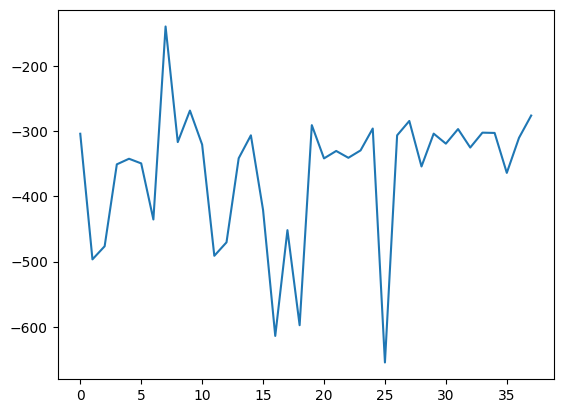

In [71]:
# Plot best average episode reward from each run over time
avg_rews = []
for i, run in enumerate(runs):
    avg_rew = run.summary['Average test episode reward']
    if isinstance(avg_rew, float):
        avg_rews.append(avg_rew)
avg_rews.reverse()
plt.plot(avg_rews)

In [100]:
# CSV file path
csv_file_path = "./hpo-trials-1.csv"

# List summary names
summary_names = [
    "Average test episode reward",
    "Average test episode length",
    "Average test step time",
]

# Get hyperparameter names
hparam_names = [hparam['name'] for hparam in hparams]

print()

# Create CSV with HPO trial results
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["name"] + summary_names + hparam_names)
    for run in runs:
        row = [run.name]
        for name in summary_names:
            row.append(run.summary[name])
        for name in hparam_names:
            row.append(run.config[name])
        writer.writerow(row)